# Tokenization and Word Embeddings

### The Goal

To translate human language into numbers that a computer can understand, in a way that preserves the meaning and relationships between words.

## 1. Setup


In [ ]:
# Run these installations if you don't have the libraries yet
!pip install nltk torch transformers
!pip install numpy==1.26.4 scipy==1.11.4 gensim==4.3.2


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import numpy as np
import gensim.downloader as api
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Download necessary NLTK data
nltk.download('punkt') # for tokenization
nltk.download('punkt_tab')
nltk.download('stopwords') # for identifying stopwords

print("Setup complete!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Setup complete!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 2. Tokenization

Tokenization is like breaking a LEGO model down into its individual bricks.

Let's take a couple of sentences and see how `NLTK` handles it.

In [ ]:
sentence = "Apple is looking at buying U.K. startup for $1 billion."

# Use the word_tokenize function from NLTK
tokens = word_tokenize(sentence)

print("Original Sentence:", sentence)
print("Tokens:", tokens)

print("\n--- NLTK's Intelligence ---")
stop_words = set(stopwords.words('english'))
for token in tokens:
    is_punct = token in string.punctuation
    is_stop = token.lower() in stop_words
    print(f"{token:<10} | Is Punctuation? {is_punct:<5} | Is Stopword? {is_stop:<5}")

Original Sentence: Apple is looking at buying U.K. startup for $1 billion.
Tokens: ['Apple', 'is', 'looking', 'at', 'buying', 'U.K.', 'startup', 'for', '$', '1', 'billion', '.']

--- NLTK's Intelligence ---
Apple      | Is Punctuation? 0     | Is Stopword? 0    
is         | Is Punctuation? 0     | Is Stopword? 1    
looking    | Is Punctuation? 0     | Is Stopword? 0    
at         | Is Punctuation? 0     | Is Stopword? 1    
buying     | Is Punctuation? 0     | Is Stopword? 0    
U.K.       | Is Punctuation? 0     | Is Stopword? 0    
startup    | Is Punctuation? 0     | Is Stopword? 0    
for        | Is Punctuation? 0     | Is Stopword? 1    
$          | Is Punctuation? 1     | Is Stopword? 0    
1          | Is Punctuation? 0     | Is Stopword? 0    
billion    | Is Punctuation? 0     | Is Stopword? 0    
.          | Is Punctuation? 1     | Is Stopword? 0    


Notice that NLTK also does a great job separating words and punctuation. To check for things like stopwords, we need to import the list from `nltk.corpus` and check against it manually, which shows how NLTK is more of a "toolkit" where you bring the pieces together yourself.

### 2.5 Handling the Details: Special Tokens

When we build a vocabulary for a model, we need a few special tokens to handle the practical realities of processing text data. These are like utility tools that make our models more robust.

#### `<PAD>` (Padding)
Neural networks are most efficient when they process data in batches. To do this, all sequences in a batch must have the **same length**. But sentences are naturally different lengths!
* **Problem:** Sentence A has 5 tokens, Sentence B has 8.
* **Solution:** We use the `<PAD>` token to fill up the shorter sentences until they match the length of the longest sentence in the batch.
* **Example:**
    `['The', 'cat', 'sat', '.']` -> `['The', 'cat', 'sat', '.', '<PAD>', '<PAD>', '<PAD>']`

The model is then designed to ignore these padding tokens during calculations.

#### `<UNK>` (Unknown)
A model can only know the words it saw during training. What happens when it encounters a new word it's never seen before (an "out-of-vocabulary" word)?
* **Problem:** The model was trained on a vocabulary that doesn't include the word "serendipity".
* **Solution:** We replace the new word with the `<UNK>` token. This allows the model to continue processing the sentence without crashing, even though it doesn't know that specific word's meaning.

#### `<SOS>` (Start of Sentence) / `<CLS>` (Classification)
It's often useful for a model to know when a new sequence is beginning.
* **`<SOS>` (Start of Sentence/Sequence):** This token is placed at the beginning of an input sequence. It acts as a starting signal, which is especially important in models that generate text (like machine translation), telling them, "Okay, start generating the output now."
* **`<CLS>` (Classification):** In models like BERT, this token is added to the start of the input. Its corresponding output from the model is then used as a summary of the entire sentence, which is perfect for classification tasks (like sentiment analysis).

#### `<EOS>` (End of Sentence) / `<SEP>` (Separator)
Just as important as knowing when to start is knowing when to stop.
* **`<EOS>` (End of Sentence/Sequence):** This token marks the end of a sequence. In text generation tasks, the model learns that when it produces an `<EOS>` token, its job is done and it should stop generating more words.
* **`<SEP>` (Separator):** In models like BERT that can take two sentences as input (e.g., for question-answering), the `<SEP>` token is used to mark the boundary between the first and second sentence.

## 3. Word Embeddings

A word embedding is like a set of GPS coordinates that places a word in a high-dimensional "meaning space."

While NLTK is great for tokenization, it doesn't come packaged with pre-trained word vectors like some spaCy models do. For this, we'll use another excellent library, `gensim`, to download and explore pre-trained GloVe vectors.

### 3.1. Looking at a Word Vector

Let's load a model and see the vector for a word.

In [ ]:
# This will download the GloVe model (around 128MB)
glove_vectors = api.load('glove-wiki-gigaword-100')

# Get the vector for the word 'king'
word = "king"
king_vector = glove_vectors[word]

print("Word:", word)
print("Vector Shape:", king_vector.shape)
print("Vector (first 10 values):", king_vector[:10])

[==================================================] 100.0% 128.1/128.1MB downloaded
Word: king
Vector Shape: (100,)
Vector (first 10 values): [-0.32307 -0.87616  0.21977  0.25268  0.22976  0.7388  -0.37954 -0.35307
 -0.84369 -1.1113 ]


### Semantic Similarity

Words with similar meanings should have similar vectors (be "close" to each other). We can measure the similarity between vectors using a metric called Cosine Similarity. `gensim` has a handy `.similarity()` method for this.

In [ ]:
print(f"Similarity(king, queen)    -> {glove_vectors.similarity('king', 'queen'):.4f}")
print(f"Similarity(king, prince)   -> {glove_vectors.similarity('king', 'prince'):.4f}")
print(f"Similarity(queen, prince)  -> {glove_vectors.similarity('queen', 'prince'):.4f}")
print("--------------------------------------")
print(f"Similarity(king, spaghetti) -> {glove_vectors.similarity('king', 'spaghetti'):.4f}")

Similarity(king, queen)    -> 0.7508
Similarity(king, prince)   -> 0.7682
Similarity(queen, prince)  -> 0.6641
--------------------------------------
Similarity(king, spaghetti) -> 0.0660


As expected, the words related to royalty are highly similar to each other, while `king` and `spaghetti` have a very low similarity score. The embedding works!

### 3.3. Visualizing the "Meaning Space"

We can't visualize 100 dimensions, but we can use an algorithm like **t-SNE** to project the vectors down to 2 dimensions. This will let us see how the words are clustered.

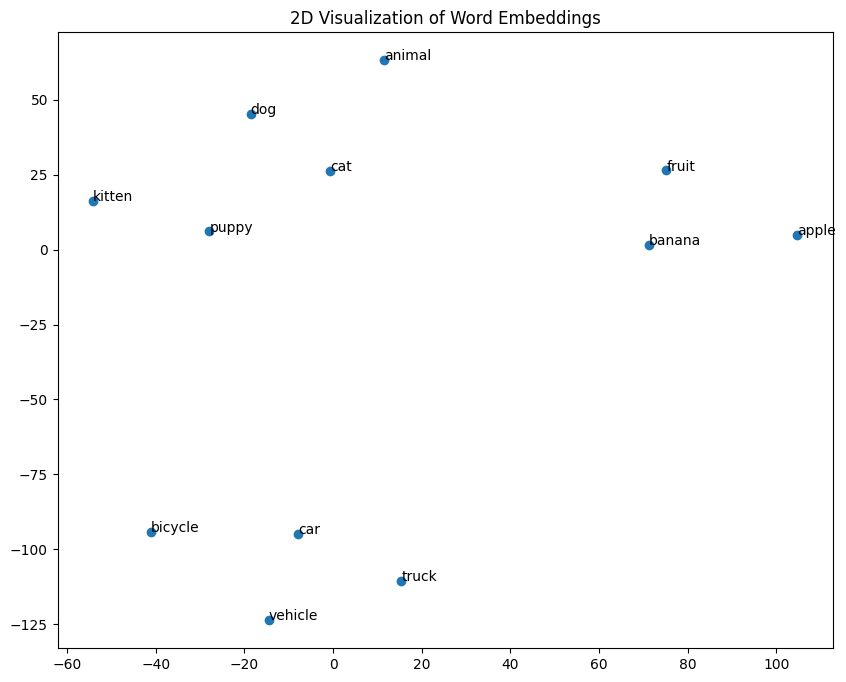

In [ ]:
words = ['dog', 'cat', 'puppy', 'kitten', 'animal', 'car', 'truck', 'bicycle', 'vehicle', 'apple', 'banana', 'fruit']
vectors = np.array([glove_vectors[word] for word in words])

# Use t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
vectors_2d = tsne.fit_transform(vectors)

# Plot the words
plt.figure(figsize=(10, 8))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]))
plt.title('2D Visualization of Word Embeddings')
plt.show()

The words cluster into logical groups: animals, vehicles, and fruits. This visual proof is a powerful way to understand what embeddings are doing.

### 3.4. The Famous Analogy: `King - Man + Woman = Queen`

The most amazing property of word embeddings is that the relationships between words are also captured in the vector math. Our `gensim` model is perfect for this.

In [ ]:
# Find the 3 most similar words to the result of our vector math
# positive=['king', 'woman'] means we add their vectors
# negative=['man'] means we subtract its vector
result = glove_vectors.most_similar(positive=['king', 'woman'], negative=['man'], topn=3)

print("Result of 'king - man + woman':", result)

Result of 'king - man + woman': [('queen', 0.7698540687561035), ('monarch', 0.6843381524085999), ('throne', 0.6755736470222473)]


The top result is **'queen'**. The model learned the concept of gender and royalty from text data alone.

## Conclusion

Today, we've seen the two foundational steps of NLP:

1.  **Tokenization:** Breaking text into manageable pieces (including special utility tokens).
2.  **Word Embeddings:** Converting those pieces into meaningful numerical vectors.

By understanding these concepts, you now have the key to how machines can begin to comprehend and process human language.

### Next things to try
- Compare **Word2Vec, GloVe and FastText**.
- Observe how each handles rare words, out-of-vocabulary (OOV) tokens, and semantic similarity.  